In [1]:

import numpy as np
import pandas as pd
from scripts.unsupervised_utils.filter_by_noise_ratio import filter_by_noise_ratio
from scripts.unsupervised_utils.paretos import extract_pareto_front
from scripts.Training.unsupervised.grid_search_hdbscan import run_hdbscan_grid
from scripts.Training.unsupervised.grid_search_knn import run_kmeans_grid
from scripts.Training.unsupervised.run_hdbscan_combinaison import  run_hdbscan_combinations
from scripts.Training.unsupervised.grid_search_clarans import run_clara_grid
from scripts.Training.unsupervised.run_algo import kmeans_with_map , hdbscan_with_map , clara_with_map
from scripts.utils.remove_desert import save_shapefile_north_of_latitude


from scripts.unsupervisedAlgofromScratch.run_algoscratch import clustering_with_map


output_shapefile_path = "../data/shapefiles/combined/north/north.shp"


save_shapefile_north_of_latitude(
    input_shapefile_path="../data/shapefiles/combined/full/",
    output_shapefile_path=output_shapefile_path,
    latitude_cut=34.0,
)


✅ Shapefile saved:
   ../data/shapefiles/combined/north/north.shp
   (North of latitude 34.0)


GID_0  COUNTRY                                           geometry
0   DZA  Algeria  MULTIPOLYGON (((2.84413 36.74151, 2.84535 36.7...
1   TUN  Tunisia  MULTIPOLYGON (((7.55636 34.00558, 7.5602 34.01...

## Load data

In [2]:

# -----------------------------
# 1. Load your data
# -----------------------------
data_path_32 = "../data/preprocessed/preprocessed_reduced_unsupervised_32.csv"
X_data_32 = pd.read_csv(data_path_32)



data_path_10 = "../data/preprocessed/preprocessed_reduced_unsupervised_10.csv"
X_data_10 = pd.read_csv(data_path_10)

shapefile_path = "../data/shapefiles/combined/north/north.shp"

print("Data shape after sampling (k-mean):", X_data_32.shape)
print("Data shape after sampling (dbscan):", X_data_10.shape)

Data shape after sampling (k-mean): (735483, 33)
Data shape after sampling (dbscan): (735483, 12)


## K-mean

In [3]:
results = run_kmeans_grid(
    X=X_data_32,
    k_values=list(range(3, 51)),  # 3,5,7,...,49
    output_path="./results/knn_metrics.csv",
    algorithm="minibatch_kmeans",  
    batch_size=4096,
    metrics=("ch", "dbi","wcss"),
)



minibatch_kmeans Grid Search:   0%|          | 0/48 [00:00<?, ?it/s]c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
minibatch_kmeans Grid Search: 100%|██████████| 48/48 [01:06<00:00,  1.39s/it]


In [4]:
pareto = extract_pareto_front(
    csv_path="./results/knn_metrics.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

    K       init         algorithm             CH       DBI  WCSS_per_point
0   3  k-means++  minibatch_kmeans  128841.313456  1.864915       12.246133
1   4  k-means++  minibatch_kmeans  121373.946231  1.812302       11.060890
2   9  k-means++  minibatch_kmeans  118917.185988  1.412854        7.206175
3  10  k-means++  minibatch_kmeans  117905.605831  1.355813        6.767340
4  11  k-means++  minibatch_kmeans  114144.788505  1.350448        6.486347


In [5]:
results = run_kmeans_grid(
    X=X_data_32,
    k_values=[3,5,8,11,12,14,16,21,26],  # 3,5,7,...,49
    n_init=10,
    output_path="./results/knn_silhouette.csv",
    algorithm="minibatch_kmeans",  
    batch_size=4096,
    metrics=("silhouette"),
)


minibatch_kmeans Grid Search: 100%|██████████| 9/9 [16:44<00:00, 111.66s/it]


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


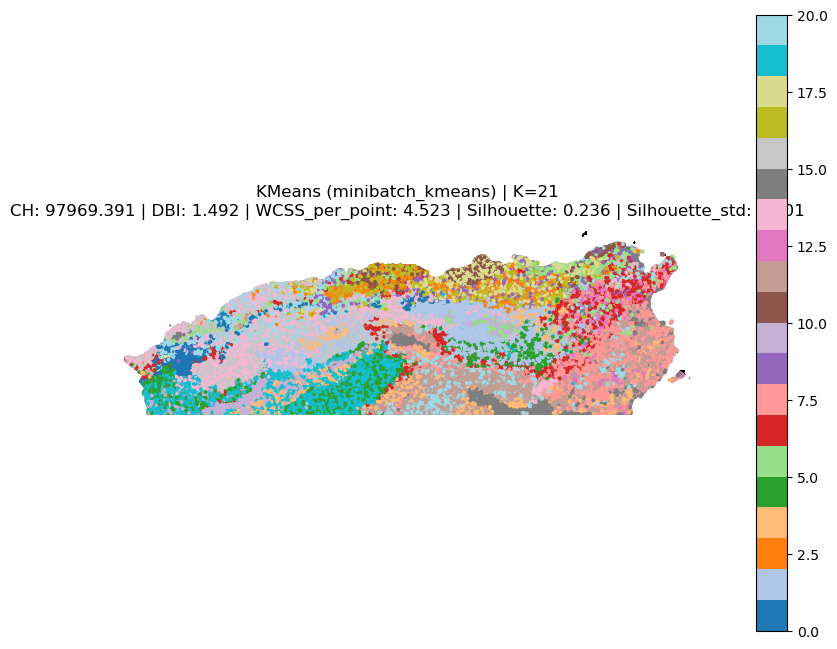

In [6]:
gdf_km, km_metrics = kmeans_with_map(
    df=X_data_32,
    shapefile_path=shapefile_path,
    k_value=21,
    algorithm="minibatch_kmeans",

)

## HDBSCAN 

In [7]:
results = run_hdbscan_grid(
    X=X_data_10,
    min_cluster_sizes=[50, 100, 200, 500, 1000],
    min_samples_values=[5, 10, 20, 50],
    output_path="./results/hdbscan_results.csv",
    metrics=("ch", "dbi", "wcss"),
)


HDBSCAN Grid Search:   0%|          | 0/20 [00:00<?, ?it/s]c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:   5%|▌         | 1/20 [03:46<1:11:47, 226.74s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 5, 'n_clusters': 4494, 'n_noise': 136333, 'noise_ratio': 0.18536526337114523, 'CH': 9768.059120023478, 'DBI': 0.836900650120119}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  10%|█         | 2/20 [07:29<1:07:23, 224.62s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 10, 'n_clusters': 4410, 'n_noise': 143423, 'noise_ratio': 0.19500518706754608, 'CH': 10155.341160197208, 'DBI': 0.8159515199591315}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  15%|█▌        | 3/20 [11:17<1:04:02, 226.04s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 20, 'n_clusters': 4279, 'n_noise': 164103, 'noise_ratio': 0.22312276422432606, 'CH': 12211.327808996735, 'DBI': 0.7780903723433401}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  20%|██        | 4/20 [15:14<1:01:26, 230.42s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 50, 'n_clusters': 3373, 'n_noise': 221045, 'noise_ratio': 0.3005439962582412, 'CH': 13006.620883074535, 'DBI': 0.6799848848712882}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  25%|██▌       | 5/20 [18:47<56:00, 224.03s/it]  

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 5, 'n_clusters': 1391, 'n_noise': 86666, 'noise_ratio': 0.11783549041922112, 'CH': 11032.661259433396, 'DBI': 0.9834705188050685}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  30%|███       | 6/20 [22:22<51:35, 221.10s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 10, 'n_clusters': 1437, 'n_noise': 95724, 'noise_ratio': 0.130151206758008, 'CH': 11134.331457155466, 'DBI': 0.950187211022234}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  35%|███▌      | 7/20 [26:05<48:02, 221.77s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 20, 'n_clusters': 1360, 'n_noise': 106020, 'noise_ratio': 0.1441501707041495, 'CH': 10973.177356100763, 'DBI': 0.9311883762882303}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  40%|████      | 8/20 [29:55<44:50, 224.22s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 50, 'n_clusters': 1176, 'n_noise': 139784, 'noise_ratio': 0.1900574180504512, 'CH': 12114.181822177805, 'DBI': 0.8537738396599395}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  45%|████▌     | 9/20 [33:26<40:21, 220.14s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 5, 'n_clusters': 598, 'n_noise': 60319, 'noise_ratio': 0.08201277255898505, 'CH': 19437.938357159794, 'DBI': 1.1464369938571846}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  50%|█████     | 10/20 [36:55<36:06, 216.66s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 10, 'n_clusters': 597, 'n_noise': 69123, 'noise_ratio': 0.09398313761161033, 'CH': 19875.8604121976, 'DBI': 1.119584586748012}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  55%|█████▌    | 11/20 [40:30<32:25, 216.18s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 20, 'n_clusters': 566, 'n_noise': 76640, 'noise_ratio': 0.10420363217096792, 'CH': 19183.306634676526, 'DBI': 1.0652460880910333}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  60%|██████    | 12/20 [44:22<29:26, 220.83s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 50, 'n_clusters': 494, 'n_noise': 91208, 'noise_ratio': 0.12401102404814252, 'CH': 22202.46141483522, 'DBI': 0.9742370841646854}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  65%|██████▌   | 13/20 [47:54<25:27, 218.14s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 5, 'n_clusters': 317, 'n_noise': 69355, 'noise_ratio': 0.09429857658164771, 'CH': 29520.134098524766, 'DBI': 1.2758619978737378}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  70%|███████   | 14/20 [51:21<21:29, 214.95s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 10, 'n_clusters': 313, 'n_noise': 69946, 'noise_ratio': 0.09510213016480326, 'CH': 30370.97202886004, 'DBI': 1.2330485707089243}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  75%|███████▌  | 15/20 [54:59<17:59, 215.90s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 20, 'n_clusters': 290, 'n_noise': 71042, 'noise_ratio': 0.09659230736808329, 'CH': 29603.934833034225, 'DBI': 1.225535998346787}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  80%|████████  | 16/20 [58:46<14:37, 219.26s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 50, 'n_clusters': 267, 'n_noise': 81106, 'noise_ratio': 0.11027583234418742, 'CH': 32101.7025179503, 'DBI': 1.1491288666570747}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  85%|████████▌ | 17/20 [1:02:13<10:46, 215.47s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 5, 'n_clusters': 177, 'n_noise': 82115, 'noise_ratio': 0.11164771993370343, 'CH': 38158.19595969905, 'DBI': 1.4310751195759062}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  90%|█████████ | 18/20 [1:05:41<07:06, 213.20s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 10, 'n_clusters': 176, 'n_noise': 92216, 'noise_ratio': 0.1253815519869256, 'CH': 38454.38521510488, 'DBI': 1.4201463195468618}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search:  95%|█████████▌| 19/20 [1:09:15<03:33, 213.52s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 20, 'n_clusters': 171, 'n_noise': 77499, 'noise_ratio': 0.10537157215054596, 'CH': 38070.87032134985, 'DBI': 1.409097706933343}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Grid Search: 100%|██████████| 20/20 [1:12:59<00:00, 218.99s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 50, 'n_clusters': 156, 'n_noise': 80387, 'noise_ratio': 0.10929824346721814, 'CH': 41141.82195409893, 'DBI': 1.2893392596333082}


In [8]:
filter_by_noise_ratio("./results/hdbscan_results.csv","./results/hdbscan_results_filtered.csv",min_noise_ratio=0.2)

Saved 54 / 60 rows to ./results/hdbscan_results_filtered.csv


In [9]:
pareto = extract_pareto_front(
    csv_path="./results/hdbscan_results_filtered.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

   algorithm  min_cluster_sizes  min_samples  n_clusters  n_noise  \
0    hdbscan                100           50        1117   133634   
1    hdbscan                 50           10        4410   143423   
2    hdbscan                100           50        1176   139784   
3    hdbscan                200           50         494    91208   
4    hdbscan                500           50         267    81106   
5    hdbscan               1000           50         156    80387   
6    hdbscan                 50           10        4410   143423   
7    hdbscan                100           50        1176   139784   
8    hdbscan                200           50         494    91208   
9    hdbscan                500           50         267    81106   
10   hdbscan               1000           50         156    80387   

    noise_ratio            CH       DBI  
0      0.181696  12354.581973  0.955520  
1      0.195005  10155.341160  0.815952  
2      0.190057  12114.181822  0.853774  
3  

In [10]:
param_combinations = [
    {"min_cluster_size": 50, "min_samples": 10},
    {"min_cluster_size": 100, "min_samples": 50},
    {"min_cluster_size": 200, "min_samples": 20},
    {"min_cluster_size": 200, "min_samples": 50},
    {"min_cluster_size": 500, "min_samples": 50},
    {"min_cluster_size": 1000, "min_samples": 50},
    
]

df = run_hdbscan_combinations(
    X=X_data_10,
    param_combinations=param_combinations,
    output_path="./results/hdbscan_selected_runs.csv",
    metrics=("ch", "dbi","silhouette"),
)


HDBSCAN Runs:   0%|          | 0/6 [00:00<?, ?it/s]c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Runs:  17%|█▋        | 1/6 [05:25<27:06, 325.23s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 10, 'n_clusters': 4410, 'n_noise': 143423, 'noise_ratio': 0.19500518706754608, 'CH': 10155.341160197208, 'DBI': 0.8159515199591315, 'Silhouette': 0.421690938847326, 'Silhouette_std': 0.0017054360671252137}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Runs:  33%|███▎      | 2/6 [10:47<21:34, 323.62s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 50, 'n_clusters': 1176, 'n_noise': 139784, 'noise_ratio': 0.1900574180504512, 'CH': 12114.181822177805, 'DBI': 0.8537738396599395, 'Silhouette': 0.3180143190618927, 'Silhouette_std': 0.0005209977578696295}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Runs:  50%|█████     | 3/6 [15:51<15:44, 314.69s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 20, 'n_clusters': 566, 'n_noise': 76640, 'noise_ratio': 0.10420363217096792, 'CH': 19183.306634676526, 'DBI': 1.0652460880910333, 'Silhouette': 0.2633783845182246, 'Silhouette_std': 0.0016929014366998502}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Runs:  67%|██████▋   | 4/6 [21:10<10:32, 316.23s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 50, 'n_clusters': 494, 'n_noise': 91208, 'noise_ratio': 0.12401102404814252, 'CH': 22202.46141483522, 'DBI': 0.9742370841646854, 'Silhouette': 0.28147480316257034, 'Silhouette_std': 0.002532384132308515}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Runs:  83%|████████▎ | 5/6 [26:23<05:15, 315.17s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 50, 'n_clusters': 267, 'n_noise': 81106, 'noise_ratio': 0.11027583234418742, 'CH': 32101.7025179503, 'DBI': 1.1491288666570747, 'Silhouette': 0.27843135065358154, 'Silhouette_std': 0.0009548235033109043}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
HDBSCAN Runs: 100%|██████████| 6/6 [31:34<00:00, 315.72s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 50, 'n_clusters': 156, 'n_noise': 80387, 'noise_ratio': 0.10929824346721814, 'CH': 41141.82195409893, 'DBI': 1.2893392596333082, 'Silhouette': 0.28475200583790805, 'Silhouette_std': 0.001638942777982889}


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


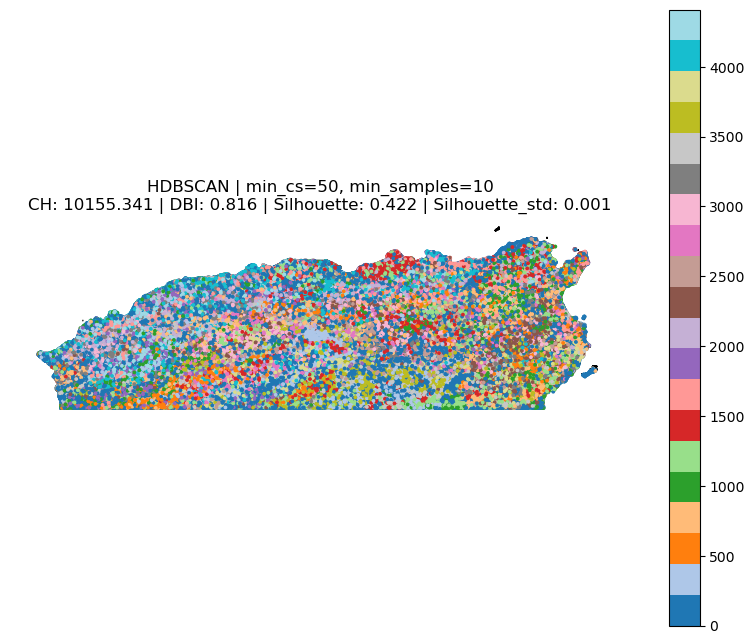

In [11]:
gdf_hdb, hdb_metrics = hdbscan_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    min_cluster_size=50,
    min_samples=10,
)

## Clarans

In [12]:
# Redémarrer le kernel d'abord (Kernel -> Restart Kernel)

# Puis réimporter
from scripts.Training.unsupervised.grid_search_clarans import run_clara_grid

# Maintenant ça devrait marcher
results = run_clara_grid(
    X=X_data_32,
    k_values=range(3, 21, 2),
    n_sampling_values=[40, 80],
    n_sampling_iter_values=[3, 5],
    max_iter_values=[300],
    output_path="./results/clara_results.csv",
    metrics=("ch", "dbi", "avg_medoid_dist"),
)


CLARA Grid Search: 100%|██████████| 36/36 [05:12<00:00,  8.69s/it]


In [13]:
pareto = extract_pareto_front(
    csv_path="./results/clara_results.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

    K  n_sampling  n_sampling_iter  max_iter algorithm     best_cost  \
0   3          40                3       300     clara  2.682655e+06   
1   3          40                5       300     clara  2.708922e+06   
2   3          80                5       300     clara  2.656007e+06   
3   5          40                3       300     clara  2.477603e+06   
4   9          80                5       300     clara  2.112577e+06   
5  15          40                3       300     clara  1.870367e+06   
6  15          80                5       300     clara  1.836285e+06   

              CH       DBI  AvgMedoidDist  
0  120462.624690  2.135016       3.647473  
1  110730.519662  2.000123       3.683187  
2  115023.007634  2.056333       3.611241  
3  106805.179721  1.721914       3.368674  
4  105583.021547  1.508455       2.872366  
5  100697.664390  1.441036       2.543046  
6  100989.533940  1.492402       2.496707  


In [14]:

best_configs = [
    {"K": 3, "n_sampling": 40, "n_sampling_iter": 3},
    {"K": 3, "n_sampling": 40, "n_sampling_iter": 5},
    {"K": 3, "n_sampling": 80, "n_sampling_iter": 5},
    {"K": 5, "n_sampling": 40, "n_sampling_iter": 3},
    {"K": 9, "n_sampling": 80, "n_sampling_iter": 5},
    {"K": 15, "n_sampling": 40, "n_sampling_iter": 3},
    {"K": 15, "n_sampling": 80, "n_sampling_iter": 5},
]

# Extraire les valeurs uniques
k_values = sorted(set([c["K"] for c in best_configs]))
n_sampling_values = sorted(set([c["n_sampling"] for c in best_configs]))
n_sampling_iter_values = sorted(set([c["n_sampling_iter"] for c in best_configs]))

print(f"K values: {k_values}")
print(f"n_sampling: {n_sampling_values}")
print(f"n_sampling_iter: {n_sampling_iter_values}")

# Grid search avec Silhouette
results = run_clara_grid(
    X=X_data_32,
    k_values=k_values,  # [3, 5, 9, 15]
    n_sampling_values=n_sampling_values,  # [40, 80]
    n_sampling_iter_values=n_sampling_iter_values,  # [3, 5]
    max_iter_values=[300],
    output_path="./results/clara_silhouette.csv",
    metrics=("ch", "dbi", "silhouette"),  # Ajout du Silhouette
)


K values: [3, 5, 9, 15]
n_sampling: [40, 80]
n_sampling_iter: [3, 5]


CLARA Grid Search: 100%|██████████| 16/16 [26:28<00:00, 99.26s/it]


In [15]:
# Charger les résultats
df_silhouette = pd.read_csv("./results/clara_silhouette.csv")

# Trier par Silhouette (décroissant = meilleur)
df_sorted = df_silhouette.sort_values('Silhouette', ascending=False)

print("Top 5 configurations par Silhouette:")
print(df_sorted[['K', 'n_sampling', 'n_sampling_iter', 
                 'CH', 'DBI', 'Silhouette', 'Silhouette_std']].head())


Top 5 configurations par Silhouette:
     K  n_sampling  n_sampling_iter             CH       DBI  Silhouette  \
11   9          80                5  100800.712316  1.462383    0.207619   
10   9          80                3   94335.209118  1.531170    0.205920   
13  15          40                5   89289.653560  1.634631    0.203423   
14  15          80                3   95063.133179  1.593293    0.201981   
15  15          80                5   93693.557523  1.636678    0.198363   

    Silhouette_std  
11        0.000966  
10        0.000474  
13        0.001623  
14        0.000852  
15        0.000415  


In [16]:
# Meilleure config = Silhouette le plus élevé
best_row = df_sorted.iloc[0]

print("\n🏆 Meilleure configuration CLARA:")
print(f"K = {int(best_row['K'])}")
print(f"n_sampling = {int(best_row['n_sampling'])}")
print(f"n_sampling_iter = {int(best_row['n_sampling_iter'])}")
print(f"\nMétriques:")
print(f"  CH = {best_row['CH']:.2f}")
print(f"  DBI = {best_row['DBI']:.3f}")
print(f"  Silhouette = {best_row['Silhouette']:.4f} ± {best_row['Silhouette_std']:.4f}")



🏆 Meilleure configuration CLARA:
K = 9
n_sampling = 80
n_sampling_iter = 5

Métriques:
  CH = 100800.71
  DBI = 1.462
  Silhouette = 0.2076 ± 0.0010


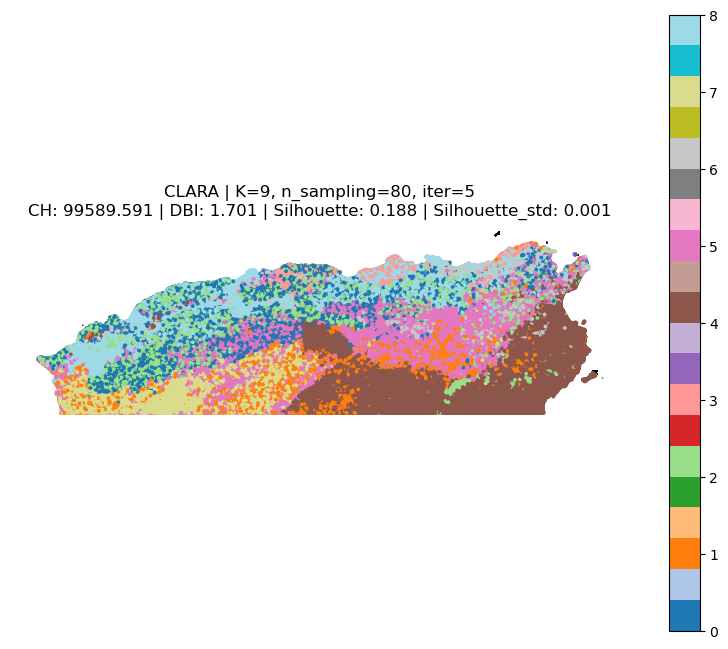

In [17]:
# Visualiser la meilleure configuration
gdf, metrics = clara_with_map(
    df=X_data_32,
    shapefile_path="../data/shapefiles/combined/north/north.shp",
    k_value=int(best_row['K']),
    n_sampling=int(best_row['n_sampling']),
    n_sampling_iter=int(best_row['n_sampling_iter']),
    max_iter=300,
    metrics=("ch", "dbi", "silhouette"),
)


In [18]:
# CLARA - avec Silhouette + CH + DBI
df_clara = pd.read_csv("./results/clara_silhouette.csv")
best_clara = df_clara.sort_values('Silhouette', ascending=False).iloc[0]

# K-Means - fusionner les deux fichiers
df_kmeans_metrics = pd.read_csv("./results/knn_metrics.csv")  # CH, DBI
df_kmeans_sil = pd.read_csv("./results/knn_silhouette.csv")    # Silhouette

# Merger sur K
df_kmeans = df_kmeans_sil.merge(
    df_kmeans_metrics[['K', 'CH', 'DBI']], 
    on='K', 
    how='left'
)
best_kmeans = df_kmeans.sort_values('Silhouette', ascending=False).iloc[0]

print("=" * 70)
print("📊 COMPARAISON CLARA vs K-MEANS")
print("=" * 70)

print(f"\n🔵 CLARA (K={int(best_clara['K'])}):")
print(f"  Silhouette: {best_clara['Silhouette']:.4f} ± {best_clara.get('Silhouette_std', 0):.4f}")
print(f"  CH:         {best_clara['CH']:.2f}")
print(f"  DBI:        {best_clara['DBI']:.3f}")
print(f"  Config:     n_sampling={int(best_clara['n_sampling'])}, iter={int(best_clara['n_sampling_iter'])}")

print(f"\n🟢 K-Means (K={int(best_kmeans['K'])}):")
print(f"  Silhouette: {best_kmeans['Silhouette']:.4f} ± {best_kmeans.get('Silhouette_std', 0):.4f}")
print(f"  CH:         {best_kmeans['CH']:.2f}")
print(f"  DBI:        {best_kmeans['DBI']:.3f}")

# Déterminer le gagnant
scores = {
    'CLARA': best_clara['Silhouette'],
    'K-Means': best_kmeans['Silhouette'],
}
winner = max(scores, key=scores.get)

print(f"\n🏆 Meilleur algorithme: {winner} ({scores[winner]:.4f})")
print("=" * 70)

# Tableau récapitulatif
comparison = pd.DataFrame({
    'Algorithme': ['CLARA', 'K-Means'],
    'K': [int(best_clara['K']), int(best_kmeans['K'])],
    'Silhouette': [f"{best_clara['Silhouette']:.4f}", f"{best_kmeans['Silhouette']:.4f}"],
    'CH': [f"{best_clara['CH']:.0f}", f"{best_kmeans['CH']:.0f}"],
    'DBI': [f"{best_clara['DBI']:.3f}", f"{best_kmeans['DBI']:.3f}"]
})

print("\n📋 TABLEAU RÉCAPITULATIF:")
print(comparison.to_string(index=False))


📊 COMPARAISON CLARA vs K-MEANS

🔵 CLARA (K=9):
  Silhouette: 0.2076 ± 0.0010
  CH:         100800.71
  DBI:        1.462
  Config:     n_sampling=80, iter=5

🟢 K-Means (K=11):
  Silhouette: 0.2374 ± 0.0008
  CH:         114144.79
  DBI:        1.350

🏆 Meilleur algorithme: K-Means (0.2374)

📋 TABLEAU RÉCAPITULATIF:
Algorithme  K Silhouette     CH   DBI
     CLARA  9     0.2076 100801 1.462
   K-Means 11     0.2374 114145 1.350


# From Scratch


### K-means


🗺️  K-MEANS CLUSTERING AVEC CARTE (K=21)
📊 Nombre de points: 735,483
📈 Features utilisées: 10
🔧 Algorithme: kmeans_scratch
⚙️  Entraînement K-means from scratch (n_init=10)...
✅ Convergence en 36 itérations

📊 Calcul des métriques...
   📈 Calinski-Harabasz: 97657.95
   📉 Davies-Bouldin: 1.435
   💾 WCSS/point: 1.051
   🎯 Calcul Silhouette (5 répétitions)...
   🎯 Silhouette: 0.2515 (±0.0007)

📊 Distribution des clusters:
   Cluster 0: 41,089 points (5.6%)
   Cluster 1: 41,938 points (5.7%)
   Cluster 2: 22,983 points (3.1%)
   Cluster 3: 46,926 points (6.4%)
   Cluster 4: 48,960 points (6.7%)
   Cluster 5: 37,154 points (5.1%)
   Cluster 6: 35,024 points (4.8%)
   Cluster 7: 11,155 points (1.5%)
   Cluster 8: 19,390 points (2.6%)
   Cluster 9: 71,944 points (9.8%)
   Cluster 10: 14,857 points (2.0%)
   Cluster 11: 26,343 points (3.6%)
   Cluster 12: 28,375 points (3.9%)
   Cluster 13: 39,063 points (5.3%)
   Cluster 14: 28,034 points (3.8%)
   Cluster 15: 14,883 points (2.0%)
   Cluster

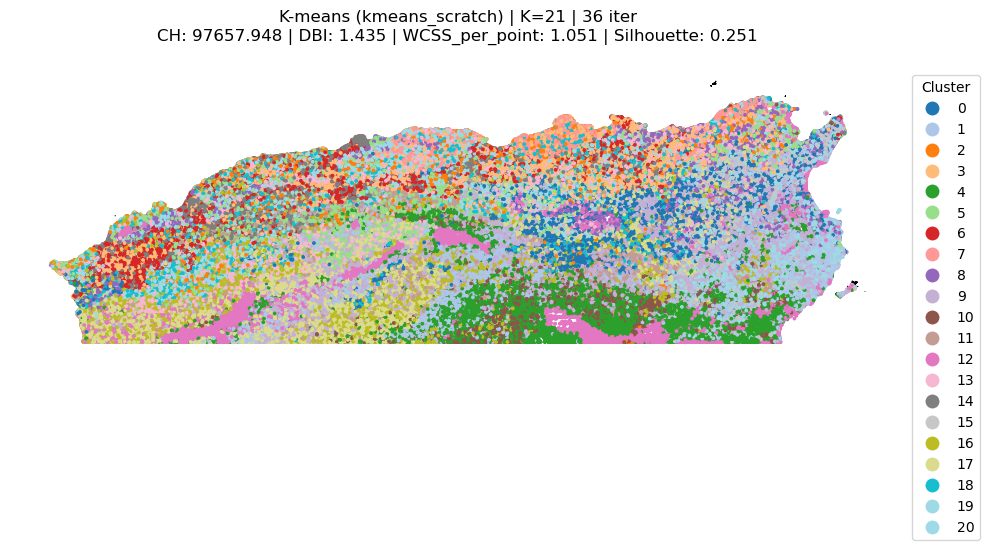

✅ Carte générée avec succès!



In [19]:
# Import
from scripts.unsupervisedAlgofromScratch.run_algoscratch import clustering_with_map

gdf_km, km_metrics = clustering_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    algorithm="kmeans_scratch",
    k_value=21,
    max_iter=300,
    n_init=10,
    metrics=("ch", "dbi", "wcss", "silhouette"),
    random_state=42,
)


# DBSCAN

In [20]:
gdf_hdbscan, hdbscan_metrics = clustering_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    algorithm="hdbscan_scratch",
    min_cluster_size=50,
    min_samples=10,
    metrics=("ch", "dbi", "silhouette"),
    random_state=42,
)



🗺️  HDBSCAN CLUSTERING AVEC CARTE (min_cluster_size=50, min_samples=10)
📊 Nombre de points: 735,483
📈 Features utilisées: 10
🔧 Algorithme: hdbscan_scratch
⚙️  Entraînement HDBSCAN from scratch...


c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\IFTA\miniconda3\envs\projetDMs\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Clustering terminé: 4410 clusters, 143423 points de bruit

📊 Calcul des métriques...
   📈 Calinski-Harabasz: 10155.34
   📉 Davies-Bouldin: 0.816
   🎯 Calcul Silhouette (5 répétitions)...
   🎯 Silhouette: 0.4244 (±0.0009)

📊 Distribution des clusters:
   Bruit: 143,423 points (19.5%)
   Cluster 0: 66 points (0.0%)
   Cluster 1: 244 points (0.0%)
   Cluster 2: 153 points (0.0%)
   Cluster 3: 136 points (0.0%)
   Cluster 4: 139 points (0.0%)
   Cluster 5: 123 points (0.0%)
   Cluster 6: 94 points (0.0%)
   Cluster 7: 55 points (0.0%)
   Cluster 8: 72 points (0.0%)
   Cluster 9: 69 points (0.0%)
   Cluster 10: 82 points (0.0%)
   Cluster 11: 62 points (0.0%)
   Cluster 12: 88 points (0.0%)
   Cluster 13: 111 points (0.0%)
   Cluster 14: 128 points (0.0%)
   Cluster 15: 96 points (0.0%)
   Cluster 16: 155 points (0.0%)
   Cluster 17: 96 points (0.0%)
   Cluster 18: 215 points (0.0%)
   Cluster 19: 187 points (0.0%)
   Cluster 20: 92 points (0.0%)
   Cluster 21: 68 points (0.0%)
   Cluster

c:\Users\IFTA\Desktop\1\DataMining-Project\src\scripts\unsupervisedAlgofromScratch\run_algoscratch.py:276: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✅ Carte générée avec succès!



# Clara


🗺️  CLARA CLUSTERING AVEC CARTE (K=9)
📊 Nombre de points: 735,483
📈 Features utilisées: 10
🔧 Algorithme: clara_scratch
⚙️  Entraînement CLARA from scratch (n_sampling=80, n_sampling_iter=5)...
✅ Clustering terminé: coût = 947925.57

📊 Calcul des métriques...
   📈 Calinski-Harabasz: 122787.50
   📉 Davies-Bouldin: 1.582
   🎯 Calcul Silhouette (5 répétitions)...
   🎯 Silhouette: 0.1984 (±0.0007)

📊 Distribution des clusters:
   Cluster 0: 97,465 points (13.3%)
   Cluster 1: 65,413 points (8.9%)
   Cluster 2: 58,098 points (7.9%)
   Cluster 3: 84,202 points (11.4%)
   Cluster 4: 120,041 points (16.3%)
   Cluster 5: 109,665 points (14.9%)
   Cluster 6: 115,446 points (15.7%)
   Cluster 7: 25,895 points (3.5%)
   Cluster 8: 59,258 points (8.1%)

🗺️  Création de la carte...


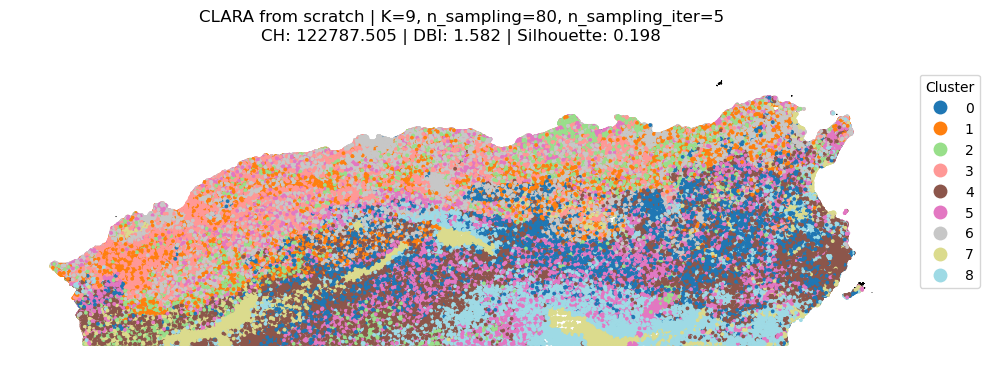

✅ Carte générée avec succès!



In [21]:
gdf_clara, clara_metrics = clustering_with_map(
    df=X_data_10,
    shapefile_path=shapefile_path,
    algorithm="clara_scratch",
    k_value=9,
    n_sampling=80,
    n_sampling_iter=5,
    metrics=("ch", "dbi", "silhouette"),
    random_state=42,
)
